# CIS 1050 Final Project

This notebook should be submitted to the Gradescope assignment. Again, only one person in the group needs to submit the file.

Note: any unused code (extra visualizations, extra cleaning, extra hypotheses/models that you tested, even hypotheses that didn't work) should be placed into a separate notebook and submitted on Gradescope (Canvas if the file is too large). Please be clear that this isn't your final submission, though (name it something like "Final Project Extra Code").

Please also submit your final dataset to Gradescope (again, Canvas if the size is too large).

# Abstract (in about 200 words or less explain what you set out to do and what you found)

In this project, I explored four hypothesis to analyze the health inspection data from NYC restaurants. THe first hypothesis investigated the inspection scores of Staten Isalnd restaurants and plotted those against other boroughs, revealing Staten Island had significantly lower scores with a p-value of 0.0. The second hypothesis compared the distribution of cuisines between the Bronx and Manhattan, using total variation distance (TVD) to confirm that these boroughs have distinctly different restaurant cuisines (p < 0.001). In the third hypothesis, we explored whether coffee/tea or pizza restaurants exhibited more critical health inspection results. The difference in critical inspection ratio was statistically significant (p < 0.001), indicating a preference for one cuisine type. Lastly, I constructed a regression model to predict health inspection scores based on cuisine type, finding that certain cuisines correlated significantly with high or lower inspection scores (p < 0.04). Together, these analyses demonstrate significant borough-based differences and cuisine-type correlations in health inspection results, helping guide food safety improvements across New York City.

# Description of Data (can be copied over from Project Proposal)

Link the site where you downloaded your data from. Also include descriptions of any merged data.

https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/data_preview

COLUMNS: CAMIS: 10-digit integer ID for an entity (restaurant)

DBA: Name of the establishments

BORO: Borough in which the establishment is (1 = MANHATTAN • 2 = BRONX • 3 = BROOKLYN • 4 = QUEENS • 5 = STATEN ISLAND • Missing; NOTE: There may be discrepancies between zip code and listed boro due to differences in an establishment's mailing address and physical location) - From the website

Street: Street Name of the Establishment location

Zipcode: Self-explanatory

Phone: Phone number provided by establishments

Cuisine Description: Restaurant's specialty, provided by restaurant owner/managers

Inspection date: Date of inspection. 1/1/1900 means an establishment has not had an inspection yet.

Action: An action that is associated with a restaurant (Either there was a violation or no violations were recorded at the time of the inspection) - "Missing" means the restaurant has yet to be inspected.

Violation Code: Common code of health inspection violation

Violation Description: Description of said corresponding code

Critical Flag: Indicator of if the violation is critical or not to restaurant's ability to operate safely.

Score: Numerical health inspection score

Grade: Grade associated with inspectation. N = not yet graded, Z= grade pending, P= grade pending on re-opening, and A-C.

Grade Date: Date grade was issued

Record Date: the date when the extraction of the data was made to create this dataset.

Insepction Type: Inspection program categorization, what was the inspection for? basically.

Latitude, Longitude: Self-explanatory Community Board: Really unknown to me but search results suggest each number corresponds to a community board/association that manages the community around establishment.

Council District - Same idea as above

Census Tract: Small permanant statistical subdivisions of a county

BIN: DOB Building Identification Nmber

BBL: Borough-block-lot identifying location of properties

NTA: Neighborhood Tabulation Areas (aggregation of census tracts)

Location Point1: NULL, no data collected/category placeholder for software application?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from google.colab import drive

drive.mount('/content/gdrive')

inspection=pd.read_csv('gdrive/My Drive/NYC_Inspection.csv')

inspection.head()

Mounted at /content/gdrive


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE DESCRIPTION,INSPECTION DATE,ACTION,...,INSPECTION TYPE,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA,Location Point1
0,40751933,SIDO FALAFEL & MORE,Manhattan,267,COLUMBUS AVENUE,10023.0,2124962803,Mediterranean,04/26/2023,Violations were cited in the following area(s).,...,Administrative Miscellaneous / Initial Inspection,40.777716,-73.978556,107.0,6.0,15700.0,1028631.0,1.011250e+09,MN14,NaN
1,50006323,LA ISLA RESTAURANT,Brooklyn,1439,MYRTLE AVENUE,11237.0,7184170668,Spanish,05/10/2022,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.698821,-73.918239,304.0,37.0,43100.0,3075417.0,3.033000e+09,BK77,NaN
2,41647897,WYTHE HOTEL BAR,Brooklyn,80,WYTHE AVENUE,11249.0,7184608000,American,01/15/2023,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.722036,-73.957736,301.0,33.0,55700.0,3335591.0,3.022880e+09,BK73,NaN
3,40367365,THE FLAME DINER,Manhattan,893,9 AVENUE,10019.0,2127657962,American,07/06/2022,Violations were cited in the following area(s).,...,Cycle Inspection / Initial Inspection,40.768432,-73.985343,104.0,6.0,13900.0,1026889.0,1.010670e+09,MN15,NaN
4,41119269,ROYAL INDIA PALACE AND RESTAURANT,Queens,11808,ATLANTIC AVENUE,11419.0,7188467600,Indian,03/01/2024,Violations were cited in the following area(s).,...,Cycle Inspection / Re-inspection,40.693861,-73.828684,409.0,28.0,12000.0,4199105.0,4.094360e+09,QN54,NaN


# Data Cleaning (this can be a direct copy of Milestone 1, and any additional steps)

In [9]:
# Dropping unnecessary or redundant columns:
drop_columns = ['PHONE', 'BUILDING', 'RECORD DATE', 'Community Board', 'Council District', 'Census Tract', 'BIN', 'NTA', 'Location Point1']

drop_columns = [col for col in drop_columns if col in inspection.columns]
inspection.drop(columns=drop_columns, inplace=True)

# Dropping Uninspected restaurants rows (1/1/1900 is uninspected)
inspection['INSPECTION DATE'] = pd.to_datetime(inspection['INSPECTION DATE'], errors='coerce')
# Drop rows where 'INSPECTION DATE' is missing or 01/01/1900
inspection = inspection[(inspection['INSPECTION DATE'].notna()) & (inspection['INSPECTION DATE'] != pd.Timestamp('1900-01-01'))]

# Ensure that no rows were missed
invalid_dates = (inspection['INSPECTION DATE'] == pd.Timestamp('1900-01-01')).sum()
invalid_dates # Yay!!

# Dropping columns with same duplicates
column_unique = ['CAMIS', 'INSPECTION DATE', 'BORO', 'STREET', 'CUISINE DESCRIPTION', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION', 'SCORE', 'GRADE', 'GRADE DATE']
inspection_cleaned = inspection.drop_duplicates(subset=column_unique)

inspection_cleaned.columns

Index(['CAMIS', 'DBA', 'BORO', 'STREET', 'ZIPCODE', 'CUISINE DESCRIPTION',
       'INSPECTION DATE', 'ACTION', 'VIOLATION CODE', 'VIOLATION DESCRIPTION',
       'CRITICAL FLAG', 'SCORE', 'GRADE', 'GRADE DATE', 'INSPECTION TYPE',
       'Latitude', 'Longitude', 'BBL'],
      dtype='object')

# Hypothesis Testing

Remember that null/inconclusive results are still valid results!

Minimum of two hypothesis tests per group member (can replace 1 per person with a regression model). If anyone in the group chooses to do only regression models, they must do at least 3 models.

You are free to explore "fancy" models/tests that use more advanced statistical/econometric knowledge outside the purview of this class for your own interest; however, you will be evaluated on the models built in the scope of the class. This is to guarantee a level playing ground between those who have that experience and those who may just be getting exposed to statistical modeling. The goal of this project isn't necessarily to find the optimum model or most precise test results but to apply what you learned from this class to data that you are interested in!

<font color = "red">Remember to hit all these points while testing your hypothesis or constructing your regression model. </font> *Please also write the name of the partner(s) who were mainly responsible for each hypothesis.*

* **Include the motivating visualization for your hypothesis test/regression**

* Hypothesis Tests:

  - What is your null hypothesis? Explicitly incorporate your test statistic into both hypotheses. That is, say something like $\mu_{Age 1} = \mu_{Age 2}$ or "Mean Age of Group 1 - Mean Age of Group 2 = 0", not just "there's no difference in average age."

  - What is your alternative hypothesis? If you're choosing a 1-tailed test, give some justification of why you're expecting this direction of difference or why you're only interested in that direction.

  - What statistic are you picking in order to assess the validity of the null hypothesis?

  - What is the observed value of the statistic?

  - What significance level are you using?

  - Histogram of hypothesis test simulations

  - Give the p-value

* Regression Models:
  - Correlation matrix, with correlations between variables of interest selected out

  - A brief "hypothesis" (e.g., "We think that `X` variable is a strong predictor of `Y`")

  - Test/train split

  - Motivating visualization (will likely be a scatter plot of some form)

  - Model evaluation ((R)MSE, residuals, etc.)
    - Include residual plot


* Short conclusion/interpretation of conclusion. Do your findings make sense, in the context of your knowledge of the topic?

## Hypothesis 1 (can copy from Milestone 2)
# **The health inspection score for Staten Island restaurants is significantly lower than for other borough restaurants.**

**(WINNY)**

Null hypothesis: The (mean health inspection score of Staten Island restaurants) - (mean health inspection score of all other borough restaurants) = 0.

Alternate hypothesis: The (mean health inspection score for Staten Island restaurants) - (mean inspection score of all other borough restaurants) < 0.

The statistic we use is the (mean of the Staten Island restaurants) - (mean of all other restaurants)

We are using the 1-tailed test for this hypothesis because in our initial analysis in the previous milestone where we ran a simulation test, we found that Staten Island restaurants had a significantly lower mean health inspection score compared to other boroughs. So it would make sense to test for that in this case.

In [23]:
observed_statistic = np.mean(inspection_cleaned[inspection_cleaned["BORO"] == "Staten Island"]["SCORE"]) - np.mean(
    inspection_cleaned[inspection_cleaned["BORO"] != "Staten Island"]["SCORE"])

observed_statistic

-2.992656802230414

The mean health inspection score of Staten Island restaurants was 3.0047 points lower than the mean of the inspection score of all other boroughs.

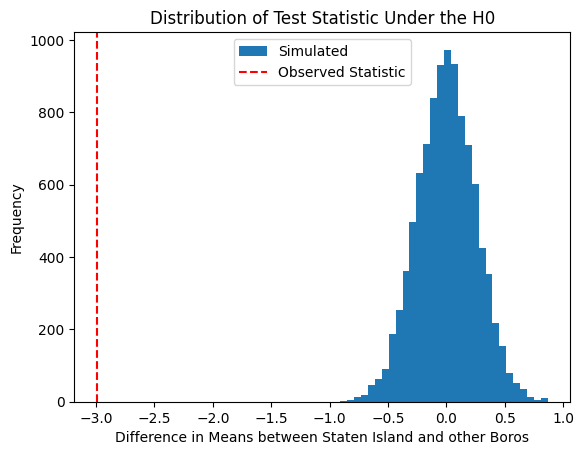

-2.992656802230414
0.0


In [24]:
num_simulations = 10000

# Simulated scores
scores = np.random.normal(loc=85, scale=10, size= num_simulations)
boroughs = np.repeat(['Manhattan', 'Brooklyn', 'Queens', 'Bronx', 'Staten Island'], 2000)

# Simulation under H0
simulated_statistics = []

for _ in np.arange(10000):
    np.random.shuffle(boroughs)
    inspection_simulated = pd.DataFrame({"BORO" : boroughs, "SCORE" : scores})
    simulated_statistic = np.mean(inspection_simulated[inspection_simulated["BORO"] == "Staten Island"]["SCORE"]) - np.mean(
    inspection_simulated[inspection_simulated["BORO"] != "Staten Island"]["SCORE"])
    simulated_statistics.append(simulated_statistic)

p_value = np.sum(np.array(simulated_statistics) <= observed_statistic) / num_simulations

# Plot
plt.hist(simulated_statistics, bins=30, label='Simulated')
plt.axvline(observed_statistic, color='r', linestyle='dashed', label='Observed Statistic')
plt.legend()
plt.title('Distribution of Test Statistic Under the H0')
plt.xlabel('Difference in Means between Staten Island and other Boros')
plt.ylabel('Frequency')
plt.show()

print(observed_statistic)
print(p_value)

The p-value is very low (0.0). We will use a significance level of 0.05, and of course the p-value is lower than that. Therefore, we reject the null hypothesis. The mean health inspection score of Staten Island is indeed lower than the mean inspection score of all other boroughs.

## Hypothesis 2

We speculate that the Bronx and Manhattan would have different types of restaurants. We assume that all restaurants go through routine health inspections, so the number of restaurants inspected for each cuisine will give us a general sense of the distribution of different cuisines in the restaurant scene for each borough.

Null hypo: The tvd of the Bronx cuisines and Manhattan cuisines is 0, meaning they have the same distribution of cuisines of investigated restaurants.

Alternative hypo: The tvd of the Bronx cuisines and Manhattan cuisines is larger than 0, meaning that they have a different distribution of cuisines of investigated restaurants.

The statistic we use is tvd.

**(NORA)**

In [ ]:
def tvd(dist1, dist2):
    return 0.5 * sum(np.abs(dist1 - dist2))

In [ ]:
inspection_bm = inspection_cleaned.pivot_table(index = 'CUISINE DESCRIPTION', columns = 'BORO', aggfunc = 'count', values = 'BBL', fill_value = 0)

inspection_bm

BORO,Bronx,Brooklyn,Manhattan,Queens,Staten Island
CUISINE DESCRIPTION,,,,,
Afghan,11,7,22,135,0
African,299,297,290,31,40
American,2307,8264,17608,6666,1487
Armenian,2,11,30,0,0
Asian/Asian Fusion,67,754,1653,1262,113
...,...,...,...,...,...
Tex-Mex,242,773,955,466,103
Thai,71,940,1503,741,70
Turkish,0,369,255,66,35


Looks like the total variation distance between the cuisine distribution of the Bronx and the cuisine distribution of Manhattan is 31988.5.

That is our observed statistic.

In [ ]:
num_bronx = sum(inspection_bm["Bronx"])

num_bronx

19501

In [ ]:
num_manhattan = sum(inspection_bm["Manhattan"])

num_manhattan

81462

In [ ]:
inspection_bm["Bronx"] = inspection_bm["Bronx"] / num_bronx
inspection_bm["Manhattan"] = inspection_bm["Manhattan"] / num_manhattan
bm_observed_stat = tvd(inspection_bm['Bronx'], inspection_bm['Manhattan'])

bm_observed_stat

0.4210921222313117

In [ ]:
tvds = []
repetitions = 1000
for i in np.arange(repetitions):

    #shuffle the dataframe up
    shuffled_inspection = inspection_cleaned.sample(len(inspection_cleaned), replace=False)
    #reset the index so that we can create our own little dataframe with the original column
    #and shuffled column side by side
    shuffled_inspection = shuffled_inspection.reset_index()

    #create a new dataframe by taking the shuffled column and lining it up
    permuted_inspection = pd.DataFrame({'boro': inspection_cleaned['BORO'], 'cuisines': inspection_cleaned['CUISINE DESCRIPTION'],
                                    'shuffled_cuisines' : shuffled_inspection['CUISINE DESCRIPTION']})
    permuted_boro_inspection = permuted_inspection.pivot_table(index='shuffled_cuisines',
                                                          columns = 'boro', values = 'cuisines',
                                                          aggfunc='count', fill_value=0)


    permuted_boro_inspection['Bronx'] = permuted_boro_inspection['Bronx'] / num_bronx
    permuted_boro_inspection['Manhattan'] = permuted_boro_inspection['Manhattan'] / num_manhattan

    #compute the statistic (the tvd) in this case
    current_tvd = tvd(permuted_boro_inspection['Bronx'], permuted_boro_inspection['Manhattan'])
    tvds.append(current_tvd)

# turning the list into an array for easier p-value calculation if needed
tvds = np.array(tvds)

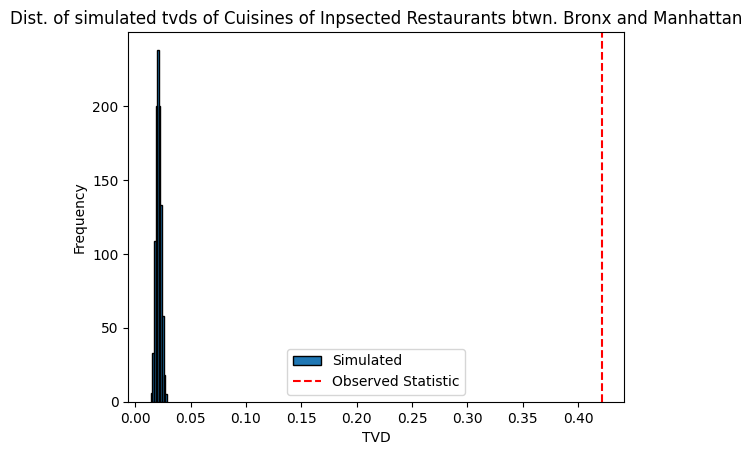

In [ ]:
# abbreviated title a bit because it was too long otherwise

plt.hist(tvds, edgecolor = "black", label = "Simulated")
plt.axvline(bm_observed_stat, linestyle = "dashed", color = "red", label = "Observed Statistic")
plt.title("Dist. of simulated tvds of Cuisines of Inpsected Restaurants btwn. Bronx and Manhattan")
plt.xlabel("TVD")
plt.ylabel("Frequency")
plt.legend();

There was actually such a big difference between the observed statistic and the simulated values that I will have to make a separate histogram without the observed statistic line to properly show the distribution of the simulated TVD values.

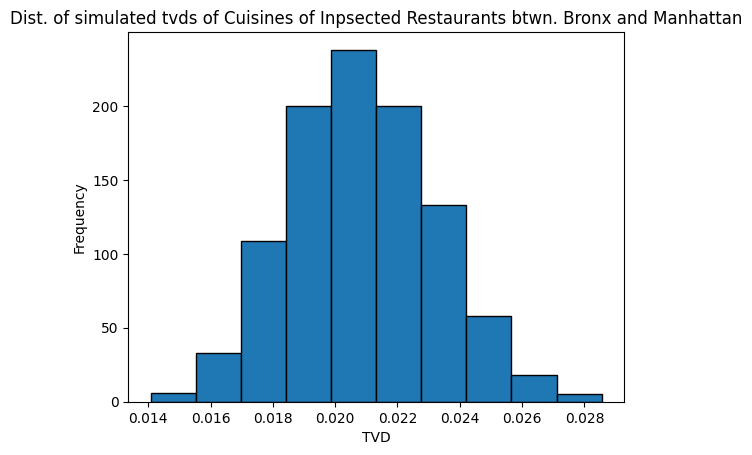

In [ ]:
plt.hist(tvds, edgecolor = "black")
plt.title("Dist. of simulated tvds of Cuisines of Inpsected Restaurants btwn. Bronx and Manhattan")
plt.xlabel("TVD")
plt.ylabel("Frequency");

In [ ]:
p_value_bm = np.sum(np.array(tvds) >= bm_observed_stat) / repetitions

p_value_bm

0.0

Again, significance level is 0.05, as is the standard for these kinds of datasets (not clinical). The p-value we got is < 0.001 or 0. So we reject the null hypothesis. The tvd of the Bronx cuisines and Manhattan cuisines is larger than 0, meaning that they have a different distribution of cuisines of investigated restaurants.

## Hypothesis 3

To delve more into the different cuisines, we were interested in studying how Critical the inspection results were for restaurants of different cuisines. We are curious about the difference in critical health level of coffee/tea restaurants vs. pizza restaurants. Specifically, we want to look at restaurants that had critical inspection results. So our question is: which cuisine type tended to have more Critical health inspection results?

Based on an analysis from milestone 1, we know that these two cuisine typess are both in the top 5 cuisines that are represented in this dataset. So we should have plenty of data.

Null hypo: The abs((ratio of "Critical" level of coffee/tea restaurants) - (ratio of "Critical" level of pizza restaurants)) = 0, meaning neither cuisine type tended to have more Critical health inspection results than the other.

Alternative hypo: The abs((ratio of "Critical" level of coffee/tea restaurants) - (ratio of "Critical" level of pizza restaurants)) =/= 0, meaning one cuisine type tended to have more Critical health inspection results than the other.

The statistic we use is abs((ratio of "Critical" level of coffee/tea restaurants) - (ratio of "Critical" level of pizza restaurants))

**(NORA)**

In [ ]:
critical = inspection_cleaned.pivot_table(index = "CRITICAL FLAG", columns = 'CUISINE DESCRIPTION', aggfunc = 'count', values = 'BBL', fill_value = 0)

critical

CUISINE DESCRIPTION,Afghan,African,American,Armenian,Asian/Asian Fusion,Australian,Bagels/Pretzels,Bakery Products/Desserts,Bangladeshi,Barbecue,...,Southeast Asian,Southwestern,Spanish,Steakhouse,Tapas,Tex-Mex,Thai,Turkish,Vegan,Vegetarian
CRITICAL FLAG,,,,,,,,,,,,,,,,,,,,,
Critical,88,561,19691,24,2240,145,1232,4748,532,303,...,592,9,3549,370,146,1222,1898,392,346,329
Not Applicable,4,14,521,0,33,4,12,60,4,15,...,7,1,75,10,5,35,12,6,5,4
Not Critical,83,382,16120,19,1576,130,942,3895,324,239,...,407,12,2582,282,101,1282,1415,327,268,288


In [ ]:
ct_critical = critical['Coffee/Tea'].iloc[0] / sum(critical['Coffee/Tea'])
pizza_critical = critical['Pizza'].iloc[0] / sum(critical['Pizza'])

crit_observed_stat = abs(ct_critical - pizza_critical)

crit_observed_stat

0.03608881229592398

*The* observed statistic is 0.03608881229592398.

In [ ]:
diff_ratios = []
repetitions = 1000
for i in np.arange(repetitions):

    #shuffle the dataframe up
    shuffled_inspection = inspection_cleaned.sample(len(inspection_cleaned), replace=False)
    #reset the index so that we can create our own little dataframe with the original column
    #and shuffled column side by side
    shuffled_inspection = shuffled_inspection.reset_index()

    permuted_inspection = pd.DataFrame({'cuisine': inspection_cleaned['CUISINE DESCRIPTION'], 'critical': inspection_cleaned['CRITICAL FLAG'],
                                    'shuffled_critical' : shuffled_inspection['CRITICAL FLAG']})
    permuted_critical_inspection = permuted_inspection.pivot_table(index='shuffled_critical',
                                                          columns = 'cuisine', values = 'critical',
                                                          aggfunc='count', fill_value=0)

    permuted_ct_critical = permuted_critical_inspection['Coffee/Tea'].iloc[0] / sum(permuted_critical_inspection['Coffee/Tea'])
    permuted_pizza_critical = permuted_critical_inspection['Pizza'].iloc[0] / sum(permuted_critical_inspection['Pizza'])

    current_stat = abs(permuted_ct_critical - permuted_pizza_critical)
    diff_ratios.append(current_stat)

# turning the list into an array for easier p-value calculation if needed
diff_ratios = np.array(diff_ratios)

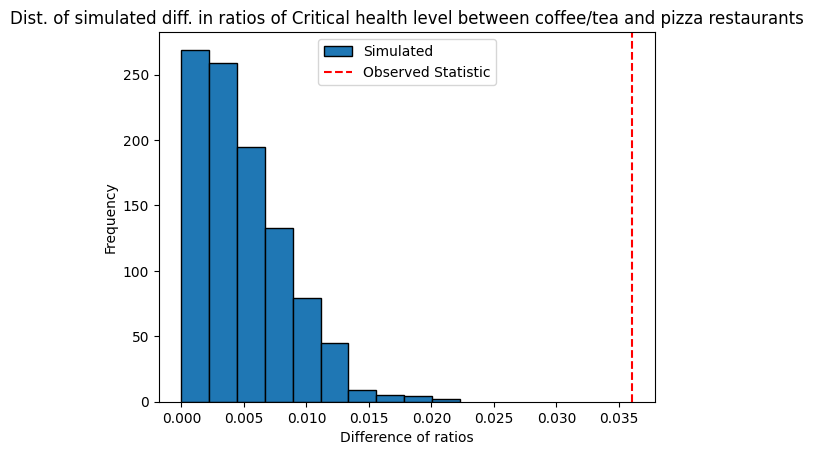

In [ ]:
plt.hist(diff_ratios, edgecolor = "black", label = "Simulated")
plt.axvline(crit_observed_stat, linestyle = "dashed", color = "red", label = "Observed Statistic")
plt.title("Dist. of simulated diff. in ratios of Critical health level between coffee/tea and pizza restaurants")
plt.xlabel("Difference of ratios")
plt.ylabel("Frequency")
plt.legend();

In [ ]:
p_value_crit = np.sum(np.array(diff_ratios) >= crit_observed_stat) / repetitions

p_value_crit

0.0

The p-value is < 0.001. Using the regular significance level of 0.05, which is apt for this analysis, we reject the null hypothesis. This means that one cuisine type tended to have more Critical health inspection results than the other.

## Hypothesis 4
Given that we've established that a one cuisine type can tend to have more critical health inspection results... I want to explore a regression model that predicts what health inspection results are predicted by certain cuisines:

The type of cuisine is a strong predictor of health inspection scores for restaurants in New York City.

If certain types of cuisines are associated with higher or lower health inspection scores, then this could be due to various factors, such as different cooking techniques, ingredients, and typical kitchen practices of each cuisine type. For example, cuisines that require more raw ingredients or complex preparation might have different scores compared to simpler cuisines.

Null Hypothesis (H0): Coefficient of cuisine types are zero. The type of the cuisine has no significant effect on the health inspection scores/
Alternative Hypothesis(H1): At least one coefficient score for cuisines is significantly different from zero, suggesting that the type of cuisine does have an impact on health inspection scores.
Statistic: T-stat.

In [12]:
# Cleaning datapoints with 'NAN' Score values
inspection_cleaned = inspection_cleaned.dropna(subset=['SCORE'])
print(inspection_cleaned.isnull().sum())

CAMIS                         0
DBA                           0
BORO                          0
STREET                        0
ZIPCODE                    2624
CUISINE DESCRIPTION           0
INSPECTION DATE               0
ACTION                        0
VIOLATION CODE              626
VIOLATION DESCRIPTION       626
CRITICAL FLAG                 0
SCORE                         0
GRADE                    102563
GRADE DATE               110995
INSPECTION TYPE               0
Latitude                    249
Longitude                   249
BBL                         622
dtype: int64


                    Coefficient  Standard Error  t-Statistic   p-Value
Intercept             25.222222        1.362868    18.506730  0.000000
African                6.344408        1.477637     4.293619  0.000018
American              -4.384127        1.366002    -3.209458  0.001330
Armenian               7.752778        3.062664     2.531384  0.011362
Asian/Asian Fusion     0.484523        1.391987     0.348080  0.727780
...                         ...             ...          ...       ...
Tex-Mex               -6.195677        1.407910    -4.400620  0.000011
Thai                  -0.456232        1.396887    -0.326606  0.743966
Turkish                0.844921        1.512371     0.558673  0.576386
Vegan                  0.553669        1.538920     0.359778  0.719014
Vegetarian            -0.809069        1.537800    -0.526121  0.598805

[89 rows x 4 columns]


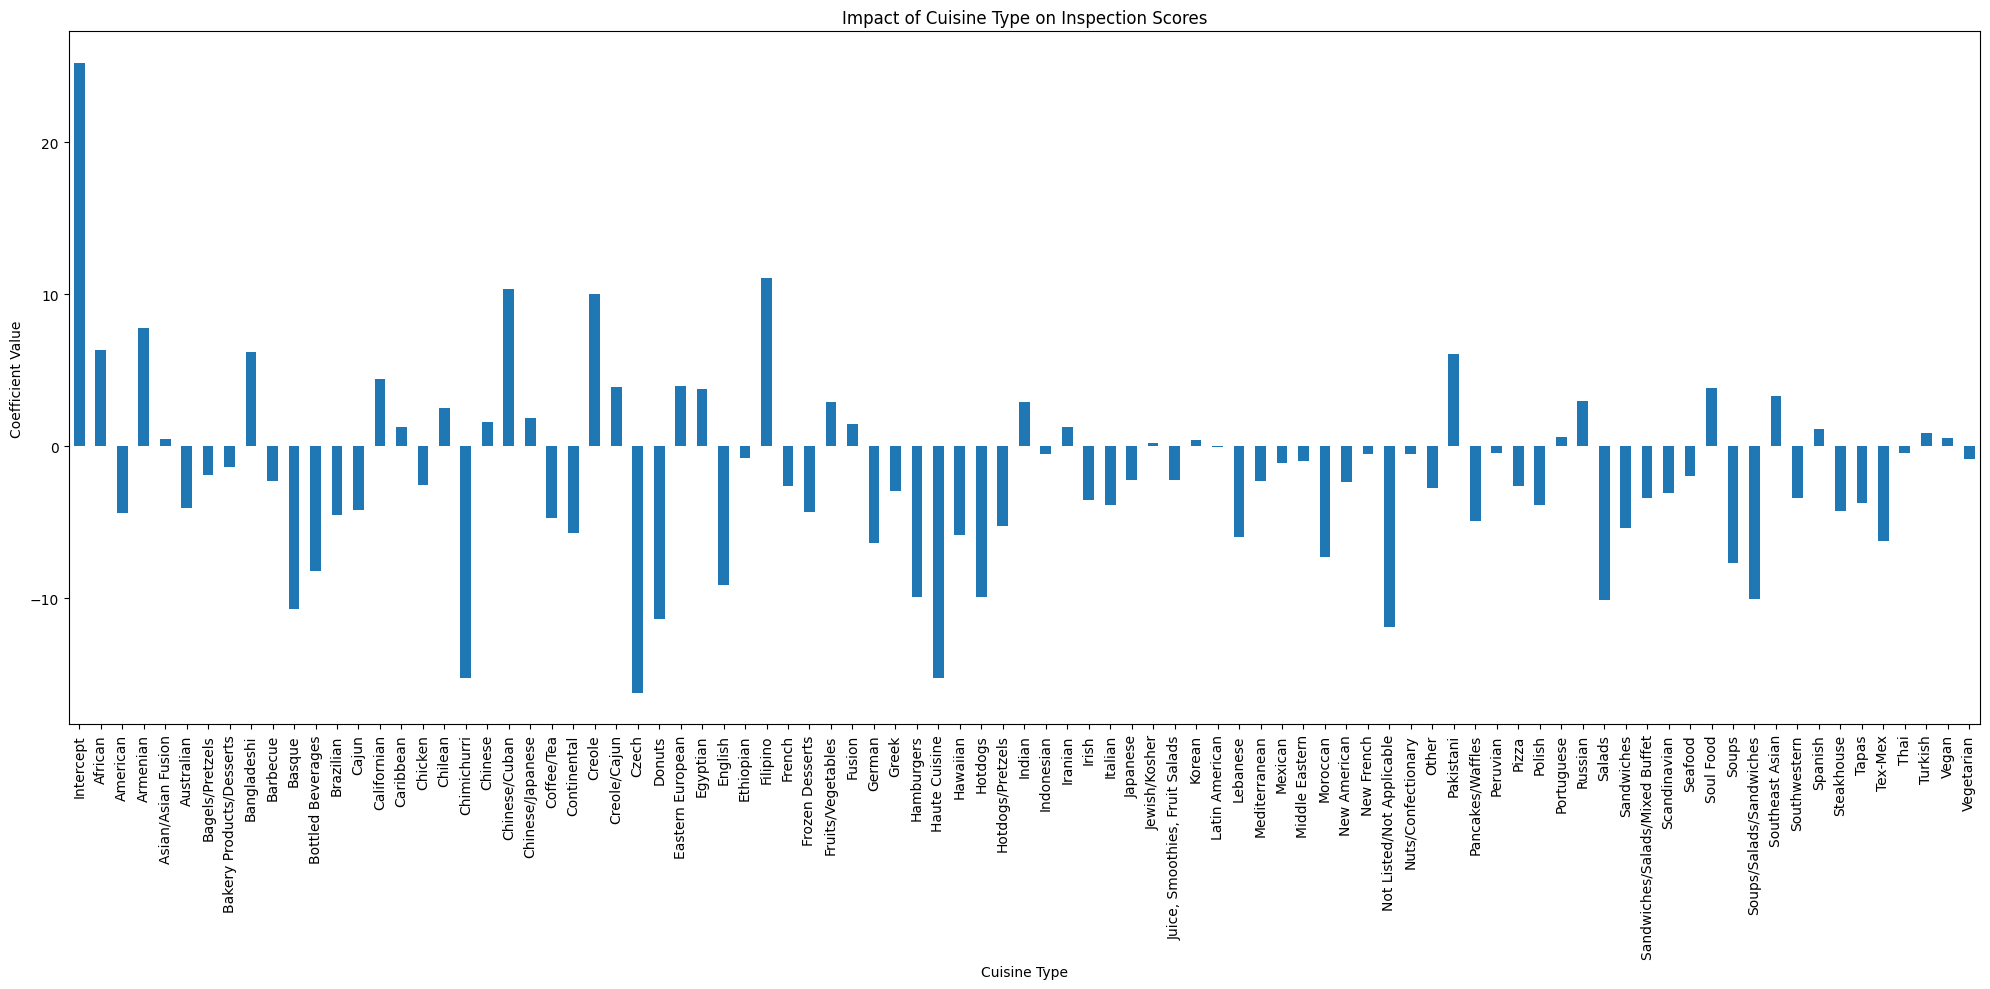

In [22]:
# Encoding 'CUISINE DESCRIPTION' into binary indicators
cuisine_dummies = pd.get_dummies(inspection_cleaned['CUISINE DESCRIPTION'], drop_first=True)

# Prepping data for regression
X = cuisine_dummies
X = np.column_stack((np.ones(len(X)), X))  # Add an intercept term to the predictor
y = inspection_cleaned['SCORE']

# Linear Regression
beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

# Calculate the residuals and the variance of the residuals
residuals = y - X @ beta_hat
residual_variance = np.sum(residuals**2) / (X.shape[0] - X.shape[1])

# Calculate the standard error of the coefficients
standard_errors = np.sqrt(np.diagonal(residual_variance * np.linalg.inv(X.T @ X)))

# Calculate the t-statistics for each coefficient
t_stats = beta_hat / standard_errors

# Calculate the p-values
from scipy.stats import t
p_values = [2 * (1 - t.cdf(np.abs(t_stat), df=X.shape[0] - X.shape[1])) for t_stat in t_stats]

# Print results
coef_summary = pd.DataFrame({'Coefficient': beta_hat, 'Standard Error': standard_errors, 't-Statistic': t_stats, 'p-Value': p_values}, index=['Intercept'] + list(cuisine_dummies.columns))
print(coef_summary)

plt.figure(figsize=(20, 10))
coef_summary['Coefficient'].plot(kind='bar')
plt.xlabel('Cuisine Type')
plt.ylabel('Coefficient Value')
plt.title('Impact of Cuisine Type on Inspection Scores')
plt.tight_layout()
plt.show()

Here I performed a regression model. The thing to pay attention to is the outputted correlation values as well as the plot itself. The intercept was calculated after dropping the first category to avoid collinearity, so it represents the **average health inspection score for a baseline cuisine**. This creates a reference point for comparing the effects of other cuisines, the coefficients for the other cuisines tell you how much higher or lower their inspection scores are relative to this baseline.

Since my intercept value is 25, then the average health inspection score for a baseline cuisine is around 25. Every other calculated coefficient score adjusts to this baseline score either above or below 0 depending on associated effects of that cuisine type on inspection scores.

This model is designed to predict health inspection scores based on different types of cuisines... cuisines with low p-values (below 0.04) indicate that the difference in health-inspection scores for these cuisines are statistically significant and unlikely due to random chance. Looking at these cuisines, we hone in on the positive or negative coefficients. Those with positive coefficients suggest cuisines that are associated with higher health scores, and negative coefficients are associated with cuisines that consistently score lower.

Non-significant cuisines (P > 0.05) suggest no statistical signifiacnce to say that their inspection scores are different from the intercept baseline due to cuisine type. This suggests other factors might hold more influence in determining inspection outcomes for these cuisines (Maybe look in PC Analysis)

## Conclusion / What are the most important takeaways from this project?

What further areas of investigation could be pursued? Are there any limitations/caveats to your findings? Any surprising conclusions? What did you learn from this project (Python skills or topic-related)?

Conclusion: The project has reveal notable trends and disparity in health inspection scores across NYC restaurants. The significant difference in scores between Staten Island and the other boroughs show a potential systemic issue specific to that borough. The differing cuisine distributions between the Bronx and Manhattan suggests unique culinary cultures in each borough, offering some insight for targeted health inspection strategies. Also, the analysis of critical health isnpectionr esults among coffee/tea and pizza restaurants highlight an importance of examining specific cuisines to identify risk factors to the health inspections. The regression model highlighted that some cuisine types are indeed more prone to higher or lower ealth inspection scores, pointing to inherent risks related to cuisine-specific practices and preparation techniques.

Future studies could dig deeper into the root of the causes of cuisine-specific risks. It could potentially be done byt analyizing the impact of restaurt size, practices in the kitchen, and ingredients that could yield risky findings. Exploring principal component analysis might also help to uncover hidden factors that influence the inspection outcomes for non-significant p-values.

The findings are limited itself may be limited to the dataset's scope that might not capture the entirety of New York Restaurants. Many of these restaurants were only included if they had a score and many restaurants were excluded simply because they'd never been inspected. Furthermore, there could be biases in the inspection process and reporting practices that should be considered when making interpretations simply because different inspectors manage different areas and could be prone to different forms of inspection rigor.

It was more surprising to find out to which extent a certain cuisine might have an impact to an associated inspection outcome. Like how Asian/Asian Fusion seems to not have its scores influenced by the type of cuisine that it is. This might suggest that there needs to be more tailored inspection approaches.

From a technical perspective, this project did well to improve our overall Python and statistical skills, particularly in data manipulation and statistical modeling. We learned the importance of considering geographic and culinary factors when inspecting restaurant health inspection scores.